In [1]:
# General Imports

import numpy as np
from PIL import Image
from astropy import nddata
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
%matplotlib inline

{'file': <astropy.io.fits.file._File <_io.BufferedReader name='rsb_fits_images/test0.fits'>>, 'filemode': 'readonly', 'hdrLoc': 2880, 'datLoc': 8640, 'datSpan': 62426880, 'filename': 'rsb_fits_images/test0.fits', 'resized': False}
18614.27476353078
561055343.0768167
0
57392


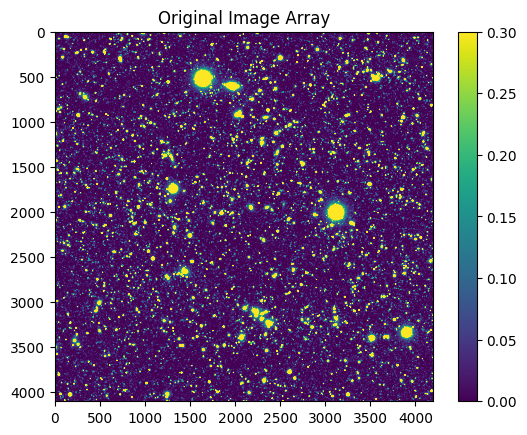

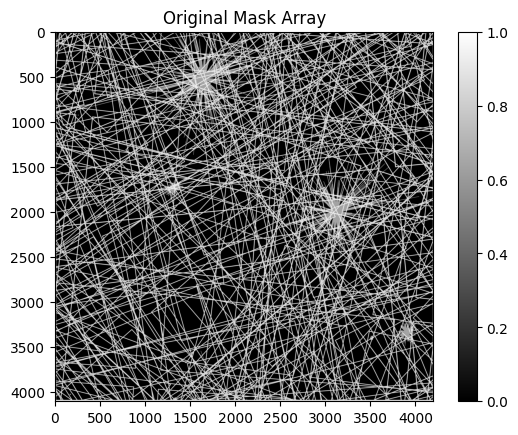

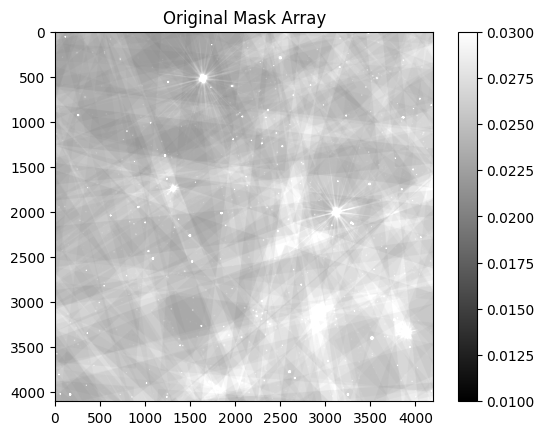

In [9]:
# Grabbing information necessary for sersic profile fit

# Opening Image
img = 'rsb_fits_images/test0.fits'
hdul = fits.open(img)
# Parsing Header
img_data = hdul[1].data            # image
mask_data = hdul[2].data           # mask
uncertainty_data = hdul[3].data    # variance
data = img_data

# Printing Out Mask Data Values
print(np.mean(mask_data))
print(np.var(mask_data))
print(np.min(mask_data))
print(np.max(mask_data))

# Normalizing Mask to Sum to One (similar to docs)
mask_max = np.max(mask_data)
mask_min = np.min(mask_data)
mask_normalized = (mask_data - mask_min)/(mask_max - mask_min)

plt.imshow(img_data.data, vmin=0, vmax=0.3)
plt.colorbar()
plt.title('Original Image Array')
plt.show()

plt.imshow(mask_normalized, cmap='gray', vmin=0, vmax=1)
plt.colorbar()
plt.title('Original Mask Array')
plt.show()
# print(np.min(uncertainty_data))

plt.imshow(uncertainty_data, cmap='gray',vmin=0.01, vmax=0.03)
plt.colorbar()
plt.title('Original Mask Array')
plt.show()


# Using Psfex Information Included within FITS file (not working)

# print(psf_image)
# print(psf_image.shape)

In [50]:
psfex_hdu_info_index = 9
psfex_hdu_data_index = 10

coadd_psf_info = hdul[21]
coadd_psf = hdul[22]


print(coadd_psf.data.columns)
print(coadd_psf.data)

# hdul.info()
# psfex_info = hdul[psfex_hdu_info_index]
# psfex_data = hdul[psfex_hdu_data_index]
# print(psfex_info.columns)
# print(psfex_info.data)

# pixstep = psfex_info.data._pixstep[0]  # Image pixel per PSF pixel
# size = psfex_data.data["_size"]  # size of PSF  (nx, ny, n_basis_vectors)
# comp = psfex_data.data["_comp"]  # PSF basis components
# coeff = psfex_data.data["coeff"]  # Coefficients modifying each basis vector
# psf_basis_image = np.roll(size, shift=-2, axis=1)
# psf_image = psf_basis_image * psfex_data.data["basis"][0, :, np.newaxis, np.newaxis]
# # psf_image
# psf_image = psf_image.sum(0)
# psf_image /= psf_image.sum()
# print(psf_image.shape)

ColDefs(
    name = 'wcs'; format = '1J'
    name = 'psf'; format = '1J'
    name = 'photoCalib'; format = '1J'
    name = 'apCorrMap'; format = '1J'
    name = 'validPolygon'; format = '1J'
    name = 'visitInfo'; format = '1J'
    name = 'transmissionCurve'; format = '1J'
    name = 'detector'; format = '1J'
    name = 'id'; format = '1K'
    name = 'bbox_min_x'; format = '1J'; unit = 'pixel'
    name = 'bbox_min_y'; format = '1J'; unit = 'pixel'
    name = 'bbox_max_x'; format = '1J'; unit = 'pixel'
    name = 'bbox_max_y'; format = '1J'; unit = 'pixel'
    name = 'goodpix'; format = '1J'
    name = 'weight'; format = '1D'
)
[(  679,   626,   631,   680,   743,   633, 0, 0, 1198467000, 0, 0, 4071, 3999,  2126590, 0.72981211)
 (  745,   744,   746,   748,   811,   812, 0, 0, 1198467003, 0, 0, 4071, 3999,  1979327, 0.72981211)
 (  813,   563,   568,   814,   875,   570, 0, 0, 1049304002, 0, 0, 4071, 3999,      337, 1.04701655)
 (  877,   876,   878,   880,   941,   942, 0, 0, 10493040

In [4]:
# Identifying Sources

# Defining Threshold in Relation to Background RMS (how bright a source must be)
from photutils.background import Background2D, MedianBackground
bkg_estimator = MedianBackground()
bkg = Background2D(img_data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
threshold = 1.9 * bkg.background_rms 


from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0
convolved_data = convolve(img_data, kernel)


# Detecting Sources --> Segmentation Map
from photutils.segmentation import detect_sources
from matplotlib.colors import LogNorm
segment_map = detect_sources(convolved_data, threshold, npixels=10)

In [5]:
# Creating Cutouts

# Acquiring Some Bounding Boxes
segment_map.remove_border_labels(10, partial_overlap=False, relabel=False)
bbox = segment_map.bbox
shortened_bbox = bbox[500:3500:30]

# Creating Same-Dimension Cutouts of Image, Mask, and Variance
cutouts = []
for i in range(len(shortened_bbox)):
    y_center, x_center = shortened_bbox[i].center
    x_len,y_len = shortened_bbox[i].shape
    min_length = 12
    if (x_len> 10 and y_len > 10 and x_len < 40 and y_len < 40):
        length = max([x_len, y_len, min_length]) * 1.25
        my_cutout = nddata.Cutout2D(img_data, (x_center,y_center), int(length))
        cutout_mask = nddata.Cutout2D(mask_data, (x_center,y_center), int(length))
        cutout_var = nddata.Cutout2D(uncertainty_data, (x_center,y_center), int(length))
        package = [my_cutout, cutout_mask, cutout_var]
        cutouts.append(package)

In [6]:
# Generating a PSF close to image dimensions:

def gen_psf(image_shape):
    psf = np.zeros(image_shape)
    center = (image_shape[0] // 2, image_shape[1] // 2)
    psf[center] = 1
    sigma = 2  
    psf = gaussian_filter(psf, sigma=sigma)
    psf /= psf.sum()
    return psf
    # plt.imshow(psf, cmap='gray')
    # plt.colorbar()
    # plt.title('Generated PSF')
    # plt.show()

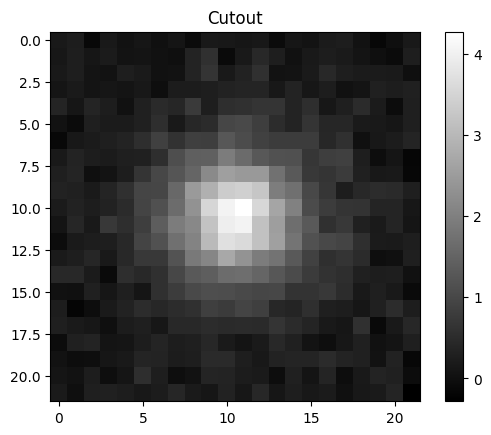

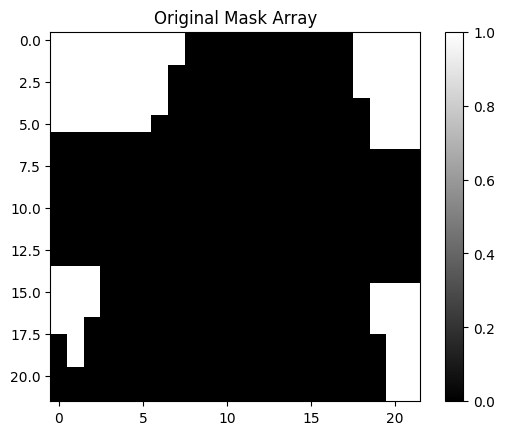

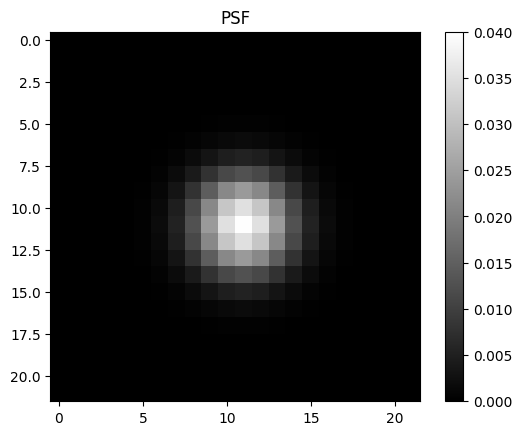

In [7]:
# Fitting a Sersic Profile

from pysersic import results
from pysersic.priors import autoprior


# Testing on One Cutout --> Estimating Values Before
im,mask,sig = cutouts[3] # image, mask, variance
prior = autoprior(image = im.data, profile_type = 'sersic', mask=mask.data, sky_type = 'none')


from pysersic import FitSingle
from pysersic.loss import student_t_loss

# Lots of Errors with FitSingle :(
# with Mask --> "more than half of of the cutout is masked"
# with PSF --> "not the right shape, didn't sum to one, not in jax format"

# Fixing PSF --> Generating Fake Generic PSF as a placeholder
psf = gen_psf(im.shape)

plt.imshow(im.data, cmap='gray')
plt.colorbar()
plt.title('Cutout')
plt.show()

# masked == white for some reason & black == source
mask_vals = mask.data <= 32
plt.imshow(mask_vals, cmap='gray', vmin=0, vmax=1)
plt.colorbar()
plt.title('Original Mask Array')
plt.show()

plt.imshow(psf, cmap='gray',vmin= 0, vmax=.04)
plt.colorbar()
plt.title('PSF')
plt.show()

# mask_flipped = np.logical_not(mask.data)
# plt.imshow(mask_flipped, cmap='gray', vmin=0, vmax=0.3)
# plt.colorbar()
# plt.title('Flipped Mask Array')
# plt.show()


fitter = FitSingle(data=im.data,rms=sig.data,mask=mask_vals,psf=psf,prior=prior,loss_func=student_t_loss)

In [21]:
from jax.random import PRNGKey # Need to use a seed to start jax's random number generation

from pysersic.priors import SourceProperties
from pysersic import check_input_data

props = SourceProperties(im.data,mask=mask.data) # Optional mask
prior = props.generate_prior('sersic', # Other profiles inclues 'exp', 'dev' and 'pointsource'
                          sky_type='none') # Can also use 'flat' or 'tilted-plane' to simultaneously fit a background
from pysersic import FitSingle
from pysersic.loss import gaussian_loss

# Checks Input Values
check_input_data(im.data, sig.data, psf, mask_vals)

fitter = FitSingle(data=im.data, # Cutout of galaxy 
                  rms=sig.data, # Cutout of pixel errors
                  psf=psf, #Point spread function
                  prior=prior, # Prior that we initialized above
                  mask=mask_vals, #Optional mask
                  loss_func=gaussian_loss) 

# fitter.sample()
# help(fitter)
# res = fitter.estimate_posterior()
# model_builder = fitter.build_model()
# model_builder()
map_params = fitter.find_MAP()

ValueError: Normal distribution got invalid loc parameter.